In [1]:
import time
import os
import sys
import numpy as np

#import ipympl
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')

import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import *
from mmtwfs.telescope import MMT

from pathlib import Path
from astropy.modeling import models, fitting

%load_ext autoreload
%autoreload 2

import lmfit

In [2]:
plt.close('all')
home = Path(os.environ['HOME'])
mmirs = WFSFactory(wfs="mmirs", nzern=21)
f9wfs = WFSFactory(wfs="newf9", nzern=21)
f5wfs = WFSFactory(wfs="f5", nzern=21)

/Users/tim/MMT/mmtwfs/mmtwfs/wfs.py:580: TableReplaceWarning: replaced column 'xcentroid' which looks like an array slice. The new column no longer shares memory with the original array.
  self.apertures['xcentroid'] = self.apertures['xcentroid'] - self.xcen
/Users/tim/MMT/mmtwfs/mmtwfs/wfs.py:581: TableReplaceWarning: replaced column 'ycentroid' which looks like an array slice. The new column no longer shares memory with the original array.
  self.apertures['ycentroid'] = self.apertures['ycentroid'] - self.ycen
/Users/tim/MMT/mmtwfs/mmtwfs/wfs.py:580: TableReplaceWarning: replaced column 'xcentroid' which looks like an array slice. The new column no longer shares memory with the original array.
  self.apertures['xcentroid'] = self.apertures['xcentroid'] - self.xcen
/Users/tim/MMT/mmtwfs/mmtwfs/wfs.py:581: TableReplaceWarning: replaced column 'ycentroid' which looks like an array slice. The new column no longer shares memory with the original array.
  self.apertures['ycentroid'] = self

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/Users/tim/conda/envs/py37/lib/python3.7/site-packages/skimage/feature/template.py:180: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


<IPython.core.display.Javascript object>


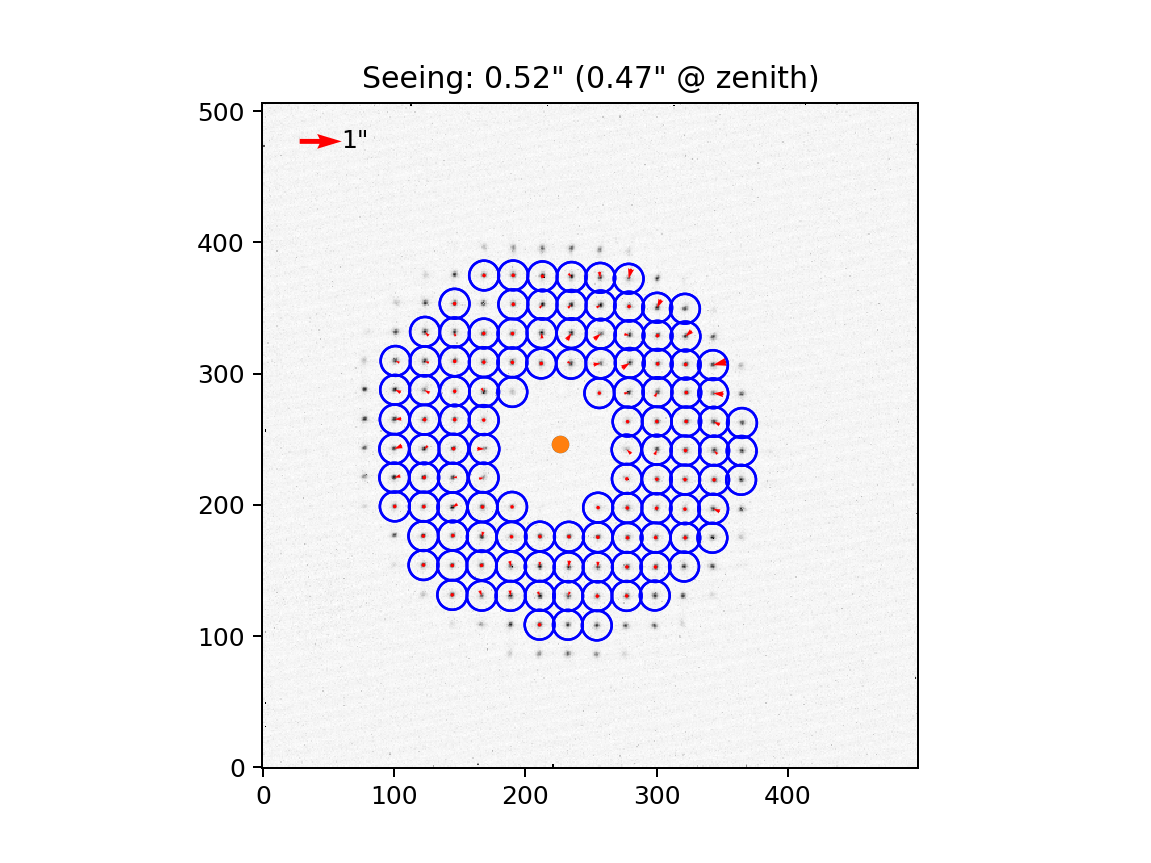

In [3]:
mmirs_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/mmirs_wfs_0150.fits"
mmirs_results = mmirs.measure_slopes(mmirs_file, plot=True)
mmirs_results['figures']['slopes'].show()

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/Users/tim/conda/envs/py37/lib/python3.7/site-packages/skimage/feature/template.py:180: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


<IPython.core.display.Javascript object>


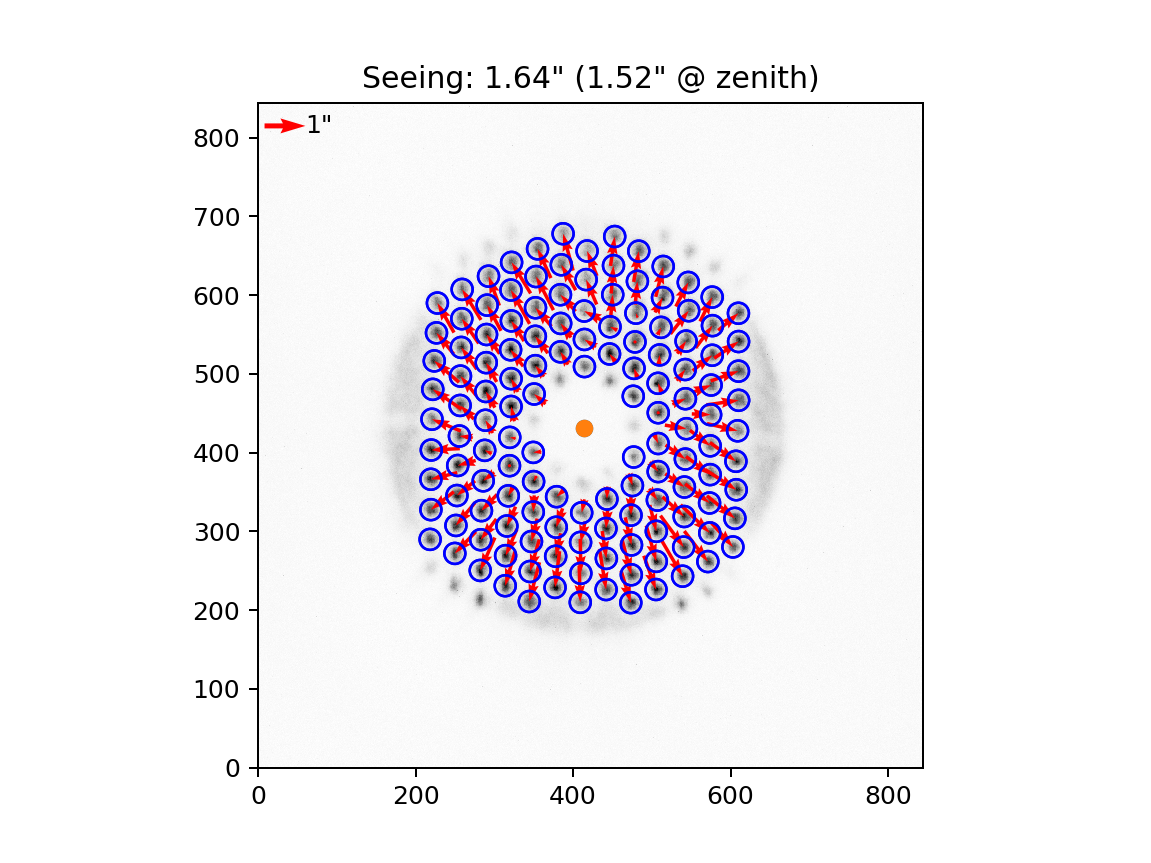

In [4]:
f9_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/test_newf9.fits"
f9_results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
f9_results['figures']['slopes'].show()

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/Users/tim/conda/envs/py37/lib/python3.7/site-packages/skimage/feature/template.py:180: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


<IPython.core.display.Javascript object>


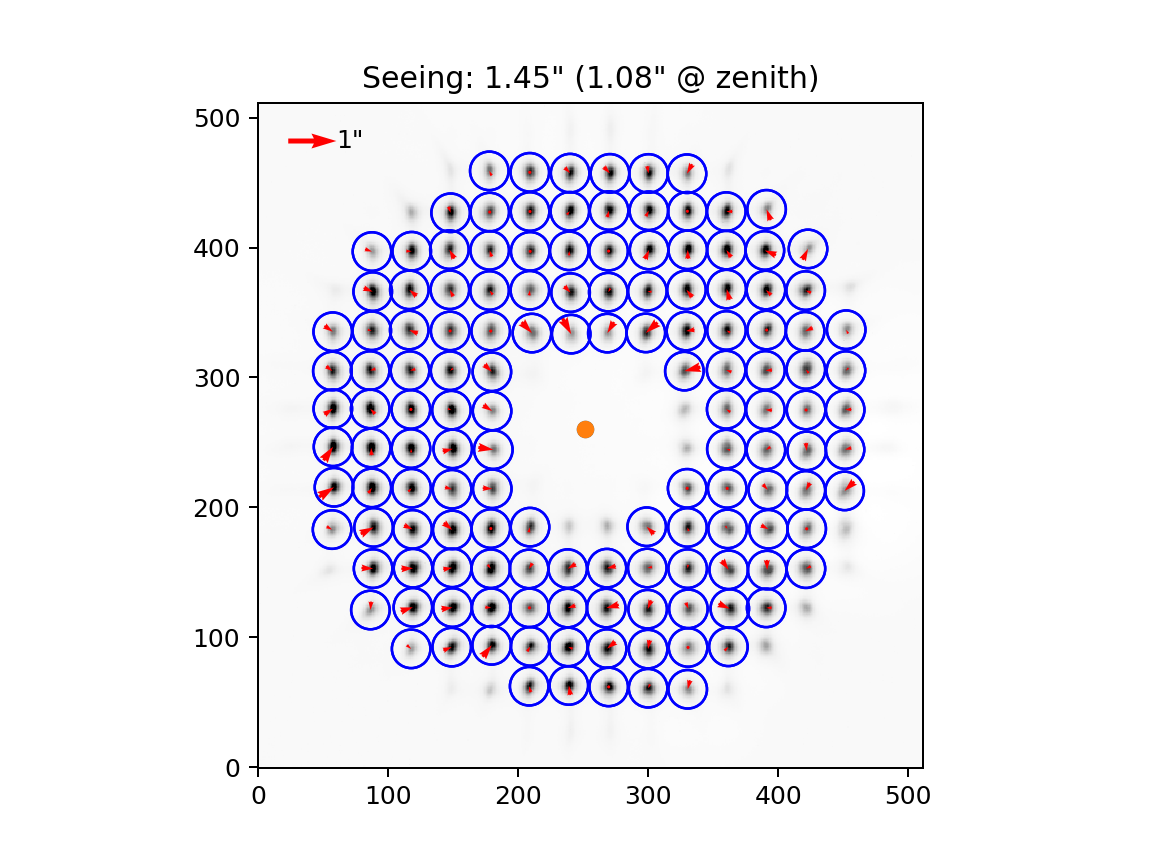

In [5]:
f5_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/auto_wfs_0037_ave.fits"
f5_results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
f5_results['figures']['slopes'].show()

In [34]:
def ZernikeGrad(zpars, x, y, atype):
    if(len(zpars) > 21):
        print('ZernikeGrad() is not implemented with >21 terms')
        return

    x2 = x * x
    y2 = y * y
    xy = x * y
    r2 = x2 + y2

    if (atype == 'dx'):
        d = 0. * x  # to make d an array with the same size as x
        d = d + zpars['Z02'] * 1.
        d = d + zpars['Z03'] * 0.
        d = d + zpars['Z04'] * 4. * x
        d = d + zpars['Z05'] * 2. * y
        d = d + zpars['Z06'] * 2. * x
        d = d + zpars['Z07'] * 6. * xy
        d = d + zpars['Z08'] * (9. * x2 + 3. * y2 - 2.)
        d = d + zpars['Z09'] * 6. * xy
        d = d + zpars['Z10'] * (3. * x2 - 3. * y2)
        d = d + zpars['Z11'] * 12. * x * (2. * (x2 + y2) - 1.)
        d = d + zpars['Z12'] * x * (16. * x2 - 6.)
        d = d + zpars['Z13'] * y * (24. * x2 + 8. * y2 - 6.)
        d = d + zpars['Z14'] * 4. * x * (x2 - 3. * y2)
        d = d + zpars['Z15'] * 4. * y * (3. * x2 - y2)
        d = d + zpars['Z16'] * (x2 * (50. * x2 + 60. * y2 - 36.) + y2 * (10. * y2 - 12.) + 3.)
        d = d + zpars['Z17'] * (xy * (40. * r2 - 24.))
        d = d + zpars['Z18'] * (x2 * (25. * x2 - 12. - 30. * y2) + y2 * (12. - 15. * y2))
        d = d + zpars['Z19'] * (4. * xy * (-6. + 15. * x2 + 5. * y2))
        d = d + zpars['Z20'] * 5. * (x2 * (x2 - 6. * y2) + y2 * y2)
        d = d + zpars['Z21'] * 20. * xy * (x2 - y2)
        d = d + zpars['Z22'] * 24. * x * (1. + x2 * (10. * y2 - 5. + 5. * x2) + y2 * (5. * y2 - 5.))

    elif (atype, 'dy'):

        d = 0. * y
        d = d + zpars['Z02'] * 0.
        d = d + zpars['Z03'] * 1.
        d = d + zpars['Z04'] * 4. * y
        d = d + zpars['Z05'] * 2. * x
        d = d + zpars['Z06'] * (-2.) * y
        d = d + zpars['Z07'] * (3. * x2 + 9. * y2 - 2.)
        d = d + zpars['Z08'] * 6. * xy
        d = d + zpars['Z09'] * (3. * x2 - 3. * y2)
        d = d + zpars['Z10'] * (-6.) * xy
        d = d + zpars['Z11'] * 12. * y * (2. * (x2 + y2) - 1.)
        d = d + zpars['Z12'] * y * (6. - 16. * y2)
        d = d + zpars['Z13'] * x * (8. * x2 + 24. * y2 - 6.)
        d = d + zpars['Z14'] * 4. * y * (y2 - 3. * x2)
        d = d + zpars['Z15'] * 4. * x * (x2 - 3. * y2)
        d = d + zpars['Z16'] * (xy * (40. * r2 - 24.))
        d = d + zpars['Z17'] * (x2 * (10. * x2 + 60. * y2 - 12.) + y2 * (50. * y2 - 36.) + 3.)
        d = d + zpars['Z18'] * (4. * xy * (6. - 5. * x2 - 15. * y2))
        d = d + zpars['Z19'] * (y2 * (-25. * y2 + 12. + 30. * x2) + x2 * (-12. + 15. * x2))
        d = d + zpars['Z20'] * 20. * xy * (y2 - x2)
        d = d + zpars['Z21'] * 5. * (x2 * (x2 - 6. * y2) + y2 * y2)
        d = d + zpars['Z22'] * 24. * y * (1. + y2 * (10. * x2 - 5. + 5. * y2) + x2 * (5. * x2 - 5.))

    return d

In [7]:
noll_coefficient(22)

2.6457513110645907

In [31]:
pars = []
for i in range(2, 23, 1):
    zpar = ("Z{:02d}".format(i), 0.0)
    pars.append(zpar)
params = lmfit.Parameters()
params.add_many(*pars)
print(params)
len(params.valuesdict())

Parameters([('Z02', <Parameter 'Z02', 0.0, bounds=[-inf:inf]>), ('Z03', <Parameter 'Z03', 0.0, bounds=[-inf:inf]>), ('Z04', <Parameter 'Z04', 0.0, bounds=[-inf:inf]>), ('Z05', <Parameter 'Z05', 0.0, bounds=[-inf:inf]>), ('Z06', <Parameter 'Z06', 0.0, bounds=[-inf:inf]>), ('Z07', <Parameter 'Z07', 0.0, bounds=[-inf:inf]>), ('Z08', <Parameter 'Z08', 0.0, bounds=[-inf:inf]>), ('Z09', <Parameter 'Z09', 0.0, bounds=[-inf:inf]>), ('Z10', <Parameter 'Z10', 0.0, bounds=[-inf:inf]>), ('Z11', <Parameter 'Z11', 0.0, bounds=[-inf:inf]>), ('Z12', <Parameter 'Z12', 0.0, bounds=[-inf:inf]>), ('Z13', <Parameter 'Z13', 0.0, bounds=[-inf:inf]>), ('Z14', <Parameter 'Z14', 0.0, bounds=[-inf:inf]>), ('Z15', <Parameter 'Z15', 0.0, bounds=[-inf:inf]>), ('Z16', <Parameter 'Z16', 0.0, bounds=[-inf:inf]>), ('Z17', <Parameter 'Z17', 0.0, bounds=[-inf:inf]>), ('Z18', <Parameter 'Z18', 0.0, bounds=[-inf:inf]>), ('Z19', <Parameter 'Z19', 0.0, bounds=[-inf:inf]>), ('Z20', <Parameter 'Z20', 0.0, bounds=[-inf:inf]>), 

21

In [33]:
def slope_chisq(pars, coords, slopes):
    parsdict = pars.valuesdict()
    x = coords[0]
    y = coords[1]
    xslope = slopes[0]
    yslope = slopes[1]
    pred_xslope = ZernikeGrad(parsdict, x, y, atype='dx')
    pred_yslope = ZernikeGrad(parsdict, x, y, atype='dy')
    d_sq = (xslope - pred_xslope)**2 + (yslope - pred_yslope)**2
    chisq = d_sq.sum()
    return chisq

In [ ]:
slopes = -f5wfs.tiltfactor * f5_results['slopes']
pup_coords = f5wfs.modes['hecto']['reference'].pup_coords(f5wfs.pup_size/2.)

In [ ]:
#zfit = np.zeros(21)
#results = optimize.minimize(slope_chisq, zfit, args=(pup_coords, slopes), method='BFGS')


In [ ]:
results['x']

In [ ]:
z = ZernikeVector()
z.from_array(results['x'], modestart=2)
z

In [ ]:
zresults = f5wfs.fit_wavefront(f5_results, plot=True)
print(zresults['residual_rms'])
print(zresults['raw_zernike'].pretty_print())
zresults['resid_plot'].show()

In [ ]:
testdata, hdr = check_wfsdata("/Users/tim/mmirs_wfs_0120.fits", header=True)

In [ ]:
mmirs.reference_aberrations('mmirs1', hdr=hdr)

In [ ]:
610/40.8

In [ ]:
np.sqrt((415/3)**2 + (1528/3)**2)

In [ ]:
np.sqrt(67**2 + 7**2)

In [ ]:
mmirs.focal_plane_position(hdr)

In [ ]:
zvec = mmirs.reference_aberrations('mmirs1', hdr=hdr)
zvec

In [ ]:
zvec.rotate(angle=-90*u.deg)
zvec

In [11]:
"Z{:02d}".format(5)

'Z05'